In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import xmltodict
import base64
import numpy as np
import array

from tqdm import tqdm

from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score
from IPython.display import clear_output

# Data Preprocessings

In [3]:
def get_lead(path):
    with open(path, 'rb') as xml:
        ECG = xmltodict.parse(xml.read().decode('utf8'))
    
    augmentLeads = True
    if path.split('/')[-1][0] == '5':
        waveforms = ECG['RestingECG']['Waveform'][1]
    elif path.split('/')[-1][0] == '6':
        waveforms = ECG['RestingECG']['Waveform']
        augmentLeads = False
    else:
        waveforms = ECG['RestingECG']['Waveform']
    
    leads = {}
    
    for lead in waveforms['LeadData']:
        lead_data = lead['WaveFormData']
        lead_b64  = base64.b64decode(lead_data)
        lead_vals = np.array(array.array('h', lead_b64))
        leads[ lead['LeadID'] ] = lead_vals
    
    if augmentLeads:
        leads['III'] = np.subtract(leads['II'], leads['I'])
        leads['aVR'] = np.add(leads['I'], leads['II'])*(-0.5)
        leads['aVL'] = np.subtract(leads['I'], 0.5*leads['II'])
        leads['aVF'] = np.subtract(leads['II'], 0.5*leads['I'])
    
    return leads

In [6]:
error_files = ['6_2_003469_ecg.xml', '6_2_003618_ecg.xml', '6_2_005055_ecg.xml', '8_2_001879_ecg.xml', '8_2_002164_ecg.xml', '8_2_007281_ecg.xml', '8_2_008783_ecg.xml', '8_2_007226_ecg.xml']


train_data = []
train_labels = []
valid_data = []
valid_labels = []


train_pathes = ['data/train/arrhythmia/', 'data/train/normal/']
valid_pathes = ['data/validation/arrhythmia/', 'data/validation/normal/']

error_decode = []   # 디코딩에 실패한 데이터들..

for idx1, pathes in enumerate([train_pathes, valid_pathes]):
    
    for path in pathes:
        for file in os.listdir(path):

            if file in error_files or 'ipynb' in file:
                continue

            try:
                data = get_lead(path + file)
            except Exception as e:
                print(e)
                error_decode.append(path + file)

            listed_data = []
            keys = sorted(data.keys())
            for key in keys:
                listed_data.append(data[key])

            for idx2, i in enumerate(listed_data):
                if len(i) != 5000:
                    listed_data[idx2] = np.append(i, np.zeros(5000-len(i)))

                    
            # save each train, valid data
            if idx1== 0: 
                train_data.append(listed_data)
                if 'arrhythmia' in path:
                    train_labels.append(1)
                else:
                    train_labels.append(0)
            else:
                valid_data.append(listed_data)
                if 'arrhythmia' in path:
                    valid_labels.append(1)
                else:
                    valid_labels.append(0)

print(len(error_decode))


6_2_003469_ecg.xml
8_2_001879_ecg.xml
6_2_003618_ecg.xml
8_2_002164_ecg.xml
6_2_005055_ecg.xml
8_2_007281_ecg.xml
8_2_008783_ecg.xml
8_2_007226_ecg.xml
8


In [7]:
error_lead_len = []
for idx, i in enumerate(train_data):
    if len(i) != 12:
        error_lead_len.append(idx)
for i in error_lead_len:
    del train_data[i]
    del train_labels[i]
    

# 데이터 길이 및 lead 개수 분석

In [5]:
 데이터의 길이 분포 확인: valid는 모두 5000인것을 확인
 
 train은 60912개가 4999, 36개가 1249, 1개가 4988
 
 위의 테스크는 먼저 4999개만 0의 패딩을 붙이고 나머지는 제외하는식으로 전처리함
딱 한개의 9 lead의 데이터가 존재한다..

0
524436
0


## 데이터 시각화
특정 데이터의 12개 lead를 모두 차트로 출력한다.  
각 lead들은 Moving average로 Data Smoothing 과정을 거친다.

In [6]:
import matplotlib.pyplot as plt

def view_lead(leads):
    size = 5 # window size
    
    for key, lead in leads.items():
        amplitude = []
        
#         for i in range(0, len(lead), 5):
#             amplitude[i+1:i+5] = (amplitude[i]+amplitude[min(len(lead)-1, i+5)])/2

        ## Smoothing (Moving Average)
        for i in range(size, len(lead)-size):
            window = lead[i-size:i+size+1]
            amplitude.append(sum(window)/len(window))
        time = np.arange(0, len(amplitude))
        
        plt.figure(num=1, dpi=100, facecolor='white', figsize=(10,1), linewidth=5.0)
        plt.plot(time, amplitude, color='blue', linewidth=0.5)
        
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        plt.show()

        
view_lead(data)

43703
0
0


# Dataset 생성

In [7]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(valid_data).float(), torch.tensor(valid_labels))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [171]:
# residual과 dropout 추가 필요
class Classifier(nn.Module):
    def __init__(self, drop_out=0.0):
        super(Classifier,self).__init__()
        self.cnn1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5, padding=2) 
        self.cnn2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
    
        self.pool1 = nn.MaxPool1d(4)
        self.pool2 = nn.MaxPool1d(5)
        self.pool3 = nn.MaxPool1d(5)
    
        self.fc1 = nn.Linear(128 * 50, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        
        
        self.relu = nn.ReLU()
        
        self.drop_out = nn.Dropout(p=drop_out)
        
        
    def forward(self, x):
        x = self.relu(self.cnn1(x))
        x = self.pool1(x)
        x = self.relu(self.cnn2(x))
        x = self.pool2(x)
        x = self.relu(self.cnn3(x))
        x = self.pool3(x)

        x = x.view(-1, 128*50)
        
        x = self.relu(self.fc1(x))
        x = self.drop_out(x)
        x = self.relu(self.fc2(x))
        x = self.drop_out(x)
        x = self.relu(self.fc3(x))
        x = self.drop_out(x)
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        
        x = torch.sigmoid(x)
        
        return x.view(-1)

In [154]:
# residual과 dropout 추가 필요
class RC_Classifier(nn.Module):
    def __init__(self, drop_out=0.0):
        super(RC_Classifier, self).__init__()
        
        n_layers = 2
        channel_size = 12
        hidden_size = 128
        
        self.cnn1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5, padding=2)
        self.cnn2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
    
        self.pool1 = nn.MaxPool1d(4)
        self.pool2 = nn.MaxPool1d(5)
        self.pool3 = nn.MaxPool1d(5)
        
        self.rnn = nn.GRU(hidden_size, hidden_size//2, n_layers, batch_first=True, bidirectional=True, dropout=drop_out)
    
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        
        self.drop_out = nn.Dropout(p=drop_out)
        
        
    def forward(self, x):
        x = self.relu(self.cnn1(x)) # output (batch, 32, 5000)
        x = self.pool1(x)           # (batch, 32, 1250)
        x = self.relu(self.cnn2(x)) # (batch, 64, 1250)
        x = self.pool2(x)           # (batch, 64, 250)
        x = self.relu(self.cnn3(x)) # (batch, 128, 250)
        x = self.pool3(x)           # (batch, 128, 50)

        x = x.permute(0,2,1)
        
        output, hidden = self.rnn(x)
        hidden = torch.cat((hidden[-2], hidden[-1]), -1) #(32,256)
        
        x = self.relu(self.fc1(hidden))
        x = self.drop_out(x)
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(x)
        
        return x.view(-1)

In [73]:
# residual과 dropout 추가 필요
class RNN_Classifier(nn.Module):
    def __init__(self, drop_out=0.0):
        super(RNN_Classifier,self).__init__()
        n_layers = 2
        channel_size = 12
        hidden_size = 128
        self.rnn = nn.GRU(channel_size, hidden_size, n_layers, batch_first=True, bidirectional=True, dropout=drop_out)
    
        self.fc1 = nn.Linear(256,32)
        self.fc2 = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        x = x.permute(0,2,1)
        output, hidden = self.rnn(x)
        # hidden ([4, 32, 128])

        hidden = torch.cat((hidden[-2], hidden[-1]), -1) #(32,256)

        x = self.relu(self.fc1(hidden))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(x)
        
        return x.view(-1)

In [155]:
LR = 0.00001
PATIENCE = 3
FACTOR = 0.95
DROP_OUT = 0.3

In [156]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# model = Classifier(drop_out=DROP_OUT).to(device)
model = RC_Classifier(drop_out=DROP_OUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay = 0)
criterion = nn.BCELoss()

use_scheduler = True
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=PATIENCE,factor=FACTOR)

In [157]:
epoches = 100

best_val_acc = 0
best_epoch = -1

best_acc_pred = []
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for i in tqdm(range(epoches)):
    # Train
    loss_sum = 0
    true_labels = []
    pred_labels = []
    model.train()
    for e_num, (x,y) in enumerate(train_dataloader):
        x, y = x.type(torch.FloatTensor).to(device), y.type(torch.FloatTensor).to(device)
        model.zero_grad()
        pred_y = model(x)
        
        loss=criterion(pred_y,y)
        loss_sum+=loss.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))
        
    
    acc=roc_auc_score(true_labels,pred_labels)
    print(f'epoch: {i}')
#     print(f'train \t\t loss mean {loss_sum/e_num} accuracy: {acc}')
    
    # Valid
    loss_sum=0
    true_labels=[]
    pred_labels=[]
    model.eval()
    for e_num, (x,y) in enumerate(val_dataloader):
        x, y = x.type(torch.FloatTensor).to(device), y.type(torch.FloatTensor).to(device)

        pred_y = model(x)
        loss=criterion(pred_y,y)
        
        loss_sum+=loss.detach()
        
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))
    
    acc=roc_auc_score(true_labels,pred_labels)
    
    # update scheduler -EY
    if use_scheduler:
        scheduler.step(acc)
    
    if best_val_acc < acc:
        print("NEW RECODE!")
        best_acc_pred = pred_labels
        best_val_acc = acc
        best_epoch = i
        torch.save(model.state_dict(), f'cnn_model_{best_val_acc}.h5')
        
#     print(f'validataion \t loss mean {loss_sum/e_num} accuracy: {acc} ',end='\n\n')
    
print(f'best validation acc = {best_val_acc}, in epoch {best_epoch}')

  0%|                                                   | 0/100 [00:00<?, ?it/s]

epoch: 0


  1%|▍                                          | 1/100 [00:17<28:45, 17.42s/it]

NEW RECODE!
epoch: 1


  2%|▊                                          | 2/100 [00:34<28:23, 17.38s/it]

NEW RECODE!
epoch: 2


  3%|█▎                                         | 3/100 [00:52<28:04, 17.36s/it]

NEW RECODE!
epoch: 3


  4%|█▋                                         | 4/100 [01:09<27:46, 17.36s/it]

NEW RECODE!
epoch: 4


  5%|██▏                                        | 5/100 [01:26<27:32, 17.39s/it]

NEW RECODE!
epoch: 5


  6%|██▌                                        | 6/100 [01:44<27:15, 17.40s/it]

epoch: 6


  7%|███                                        | 7/100 [02:01<27:03, 17.46s/it]

NEW RECODE!
epoch: 7


  8%|███▍                                       | 8/100 [02:19<26:52, 17.53s/it]

NEW RECODE!
epoch: 8


  9%|███▊                                       | 9/100 [02:37<26:39, 17.58s/it]

NEW RECODE!
epoch: 9


 10%|████▏                                     | 10/100 [02:54<26:19, 17.55s/it]

NEW RECODE!
epoch: 10


 11%|████▌                                     | 11/100 [03:12<26:01, 17.54s/it]

epoch: 11


 12%|█████                                     | 12/100 [03:29<25:45, 17.56s/it]

NEW RECODE!
epoch: 12


 13%|█████▍                                    | 13/100 [03:47<25:26, 17.55s/it]

epoch: 13


 14%|█████▉                                    | 14/100 [04:04<25:06, 17.52s/it]

epoch: 14


 15%|██████▎                                   | 15/100 [04:22<24:49, 17.52s/it]

epoch: 15


 16%|██████▋                                   | 16/100 [04:39<24:32, 17.53s/it]

NEW RECODE!
epoch: 16


 17%|███████▏                                  | 17/100 [04:57<24:21, 17.61s/it]

epoch: 17


 18%|███████▌                                  | 18/100 [05:15<24:01, 17.58s/it]

epoch: 18


 19%|███████▉                                  | 19/100 [05:32<23:45, 17.60s/it]

NEW RECODE!
epoch: 19


 20%|████████▍                                 | 20/100 [05:50<23:28, 17.61s/it]

NEW RECODE!
epoch: 20


 21%|████████▊                                 | 21/100 [06:07<23:07, 17.57s/it]

epoch: 21


 22%|█████████▏                                | 22/100 [06:25<22:52, 17.59s/it]

epoch: 22


 23%|█████████▋                                | 23/100 [06:43<22:32, 17.57s/it]

NEW RECODE!
epoch: 23


 24%|██████████                                | 24/100 [07:00<22:16, 17.58s/it]

epoch: 24


 25%|██████████▌                               | 25/100 [07:18<21:56, 17.55s/it]

epoch: 25


 26%|██████████▉                               | 26/100 [07:35<21:39, 17.56s/it]

epoch: 26


 27%|███████████▎                              | 27/100 [07:53<21:26, 17.63s/it]

epoch: 27


 28%|███████████▊                              | 28/100 [08:11<21:15, 17.72s/it]

epoch: 28


 29%|████████████▏                             | 29/100 [08:29<20:58, 17.72s/it]

NEW RECODE!
epoch: 29


 30%|████████████▌                             | 30/100 [08:47<20:44, 17.77s/it]

epoch: 30


 31%|█████████████                             | 31/100 [09:04<20:23, 17.72s/it]

NEW RECODE!
epoch: 31


 32%|█████████████▍                            | 32/100 [09:22<19:59, 17.65s/it]

NEW RECODE!
epoch: 32


 33%|█████████████▊                            | 33/100 [09:39<19:39, 17.60s/it]

epoch: 33


 34%|██████████████▎                           | 34/100 [09:57<19:22, 17.62s/it]

epoch: 34


 35%|██████████████▋                           | 35/100 [10:14<19:03, 17.59s/it]

epoch: 35


 36%|███████████████                           | 36/100 [10:32<18:46, 17.60s/it]

epoch: 36


 37%|███████████████▌                          | 37/100 [10:50<18:27, 17.58s/it]

epoch: 37


 38%|███████████████▉                          | 38/100 [11:07<18:12, 17.62s/it]

epoch: 38


 39%|████████████████▍                         | 39/100 [11:25<17:56, 17.65s/it]

NEW RECODE!
epoch: 39


 40%|████████████████▊                         | 40/100 [11:43<17:39, 17.65s/it]

epoch: 40


 41%|█████████████████▏                        | 41/100 [12:00<17:19, 17.61s/it]

epoch: 41


 42%|█████████████████▋                        | 42/100 [12:18<17:00, 17.60s/it]

epoch: 42


 43%|██████████████████                        | 43/100 [12:35<16:41, 17.57s/it]

NEW RECODE!
epoch: 43


 44%|██████████████████▍                       | 44/100 [12:53<16:26, 17.62s/it]

epoch: 44


 45%|██████████████████▉                       | 45/100 [13:11<16:11, 17.66s/it]

epoch: 45


 46%|███████████████████▎                      | 46/100 [13:29<15:56, 17.71s/it]

epoch: 46


 47%|███████████████████▋                      | 47/100 [13:46<15:34, 17.64s/it]

epoch: 47


 48%|████████████████████▏                     | 48/100 [14:04<15:15, 17.61s/it]

epoch: 48


 49%|████████████████████▌                     | 49/100 [14:22<15:07, 17.80s/it]

NEW RECODE!
epoch: 49


 50%|█████████████████████                     | 50/100 [14:41<15:03, 18.08s/it]

epoch: 50


 51%|█████████████████████▍                    | 51/100 [14:58<14:42, 18.00s/it]

epoch: 51


 52%|█████████████████████▊                    | 52/100 [15:16<14:21, 17.96s/it]

epoch: 52


 53%|██████████████████████▎                   | 53/100 [15:34<14:00, 17.89s/it]

NEW RECODE!
epoch: 53


 54%|██████████████████████▋                   | 54/100 [15:52<13:39, 17.81s/it]

epoch: 54


 55%|███████████████████████                   | 55/100 [16:09<13:19, 17.76s/it]

epoch: 55


 56%|███████████████████████▌                  | 56/100 [16:27<13:00, 17.73s/it]

epoch: 56


 57%|███████████████████████▉                  | 57/100 [16:45<12:44, 17.78s/it]

epoch: 57


 58%|████████████████████████▎                 | 58/100 [17:03<12:31, 17.90s/it]

epoch: 58


 59%|████████████████████████▊                 | 59/100 [17:21<12:16, 17.97s/it]

epoch: 59


 60%|█████████████████████████▏                | 60/100 [17:39<12:00, 18.00s/it]

epoch: 60


 61%|█████████████████████████▌                | 61/100 [17:57<11:42, 18.02s/it]

epoch: 61


 62%|██████████████████████████                | 62/100 [18:15<11:21, 17.93s/it]

epoch: 62


 63%|██████████████████████████▍               | 63/100 [18:33<11:05, 17.99s/it]

epoch: 63


 64%|██████████████████████████▉               | 64/100 [18:52<10:53, 18.15s/it]

epoch: 64


 65%|███████████████████████████▎              | 65/100 [19:09<10:31, 18.05s/it]

epoch: 65


 66%|███████████████████████████▋              | 66/100 [19:27<10:09, 17.92s/it]

epoch: 66


 67%|████████████████████████████▏             | 67/100 [19:45<09:52, 17.96s/it]

epoch: 67


 68%|████████████████████████████▌             | 68/100 [20:03<09:34, 17.95s/it]

epoch: 68


 69%|████████████████████████████▉             | 69/100 [20:21<09:19, 18.03s/it]

epoch: 69


 70%|█████████████████████████████▍            | 70/100 [20:40<09:08, 18.28s/it]

epoch: 70


 71%|█████████████████████████████▊            | 71/100 [20:58<08:46, 18.17s/it]

epoch: 71


 72%|██████████████████████████████▏           | 72/100 [21:16<08:23, 17.99s/it]

epoch: 72


 73%|██████████████████████████████▋           | 73/100 [21:33<08:04, 17.95s/it]

epoch: 73


 74%|███████████████████████████████           | 74/100 [21:51<07:46, 17.93s/it]

epoch: 74


 75%|███████████████████████████████▌          | 75/100 [22:10<07:29, 18.00s/it]

epoch: 75


 76%|███████████████████████████████▉          | 76/100 [22:28<07:11, 18.00s/it]

epoch: 76


 77%|████████████████████████████████▎         | 77/100 [22:45<06:51, 17.89s/it]

epoch: 77


 78%|████████████████████████████████▊         | 78/100 [23:03<06:31, 17.80s/it]

epoch: 78


 79%|█████████████████████████████████▏        | 79/100 [23:22<06:19, 18.09s/it]

epoch: 79


 80%|█████████████████████████████████▌        | 80/100 [23:40<06:03, 18.15s/it]

epoch: 80


 81%|██████████████████████████████████        | 81/100 [23:58<05:43, 18.07s/it]

epoch: 81


 82%|██████████████████████████████████▍       | 82/100 [24:16<05:24, 18.00s/it]

epoch: 82


 83%|██████████████████████████████████▊       | 83/100 [24:33<05:04, 17.90s/it]

epoch: 83


 84%|███████████████████████████████████▎      | 84/100 [24:51<04:45, 17.86s/it]

epoch: 84


 85%|███████████████████████████████████▋      | 85/100 [25:09<04:27, 17.81s/it]

epoch: 85


 86%|████████████████████████████████████      | 86/100 [25:26<04:08, 17.75s/it]

epoch: 86


 87%|████████████████████████████████████▌     | 87/100 [25:44<03:49, 17.68s/it]

epoch: 87


 88%|████████████████████████████████████▉     | 88/100 [26:01<03:31, 17.63s/it]

epoch: 88


 89%|█████████████████████████████████████▍    | 89/100 [26:19<03:13, 17.61s/it]

epoch: 89


 90%|█████████████████████████████████████▊    | 90/100 [26:36<02:56, 17.61s/it]

epoch: 90


 91%|██████████████████████████████████████▏   | 91/100 [26:54<02:38, 17.61s/it]

epoch: 91


 92%|██████████████████████████████████████▋   | 92/100 [27:11<02:20, 17.50s/it]

epoch: 92


 93%|███████████████████████████████████████   | 93/100 [27:28<02:01, 17.35s/it]

epoch: 93


 94%|███████████████████████████████████████▍  | 94/100 [27:46<01:43, 17.32s/it]

epoch: 94


 95%|███████████████████████████████████████▉  | 95/100 [28:02<01:25, 17.15s/it]

epoch: 95


 96%|████████████████████████████████████████▎ | 96/100 [28:19<01:08, 17.02s/it]

epoch: 96


 97%|████████████████████████████████████████▋ | 97/100 [28:36<00:51, 17.00s/it]

epoch: 97


 98%|█████████████████████████████████████████▏| 98/100 [28:53<00:33, 16.91s/it]

epoch: 98


 99%|█████████████████████████████████████████▌| 99/100 [29:10<00:16, 16.90s/it]

epoch: 99


100%|█████████████████████████████████████████| 100/100 [29:26<00:00, 17.67s/it]

best validation acc = 0.9470746826741178, in epoch 52


In [15]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [172]:
test_model = Classifier(drop_out=DROP_OUT).to(device)

In [173]:
test_model.load_state_dict(torch.load('/home/bang/PycharmProjects/HDAI/models/6_cnn_model_0.9782253290960669.h5'))

<All keys matched successfully>

In [195]:
test_model.eval()

loss_sum=0
true_labels=[]
pred_labels=[]
test_model.eval()

for e_num, (x,y) in enumerate(val_dataloader):
    x, y = x.type(torch.FloatTensor).to(device), y.type(torch.FloatTensor).to(device)

    pred_y = test_model(x)
    loss=criterion(pred_y,y)

    loss_sum+=loss.detach()

    true_labels.extend(y.cpu().numpy())
    pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))

    
best_acc_pred = pred_labels
best_val_acc = acc
best_epoch = i
acc=roc_auc_score(true_labels,pred_labels)

In [205]:
print("AUC :", acc)

AUC : 0.9782253290960669


In [207]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    

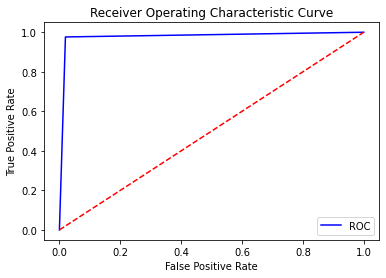

AUC : 0.9782253290960669


In [208]:
import  matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fper, tper, thresholds = roc_curve(true_labels,best_acc_pred)
plot_roc_curve(fper, tper)
print("AUC :", acc)